In [1]:
import pymc as pm
from mc import *
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import arviz as az

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")

In [2]:
# Scenarios
scenarios = [
    ('out/dy_mul', {'p_comorb': 0.1542, 'rr_risk_comorb': 4.3}, False),
    ('out/dy_add', {'p_comorb': 0.1542, 'rr_risk_comorb': 2.91}, False),
]

collect_fit = dict()
collect_post = dict()

In [3]:
for out_path, exo, completed in scenarios:
    if completed:
        continue

    os.makedirs(out_path, exist_ok=True)

    src = load_objectives(path_target='data/targets.json', exo=rco)
    model = src.build_model()
    
    with model:
        fit = pm.sample_smc(draws=500, chains=3)
        ppost = pm.sample_posterior_predictive(fit)
        
    collect_fit[out_path] = fit
    collect_post[out_path] = ppost

/opt/conda/envs/pymc-dev/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


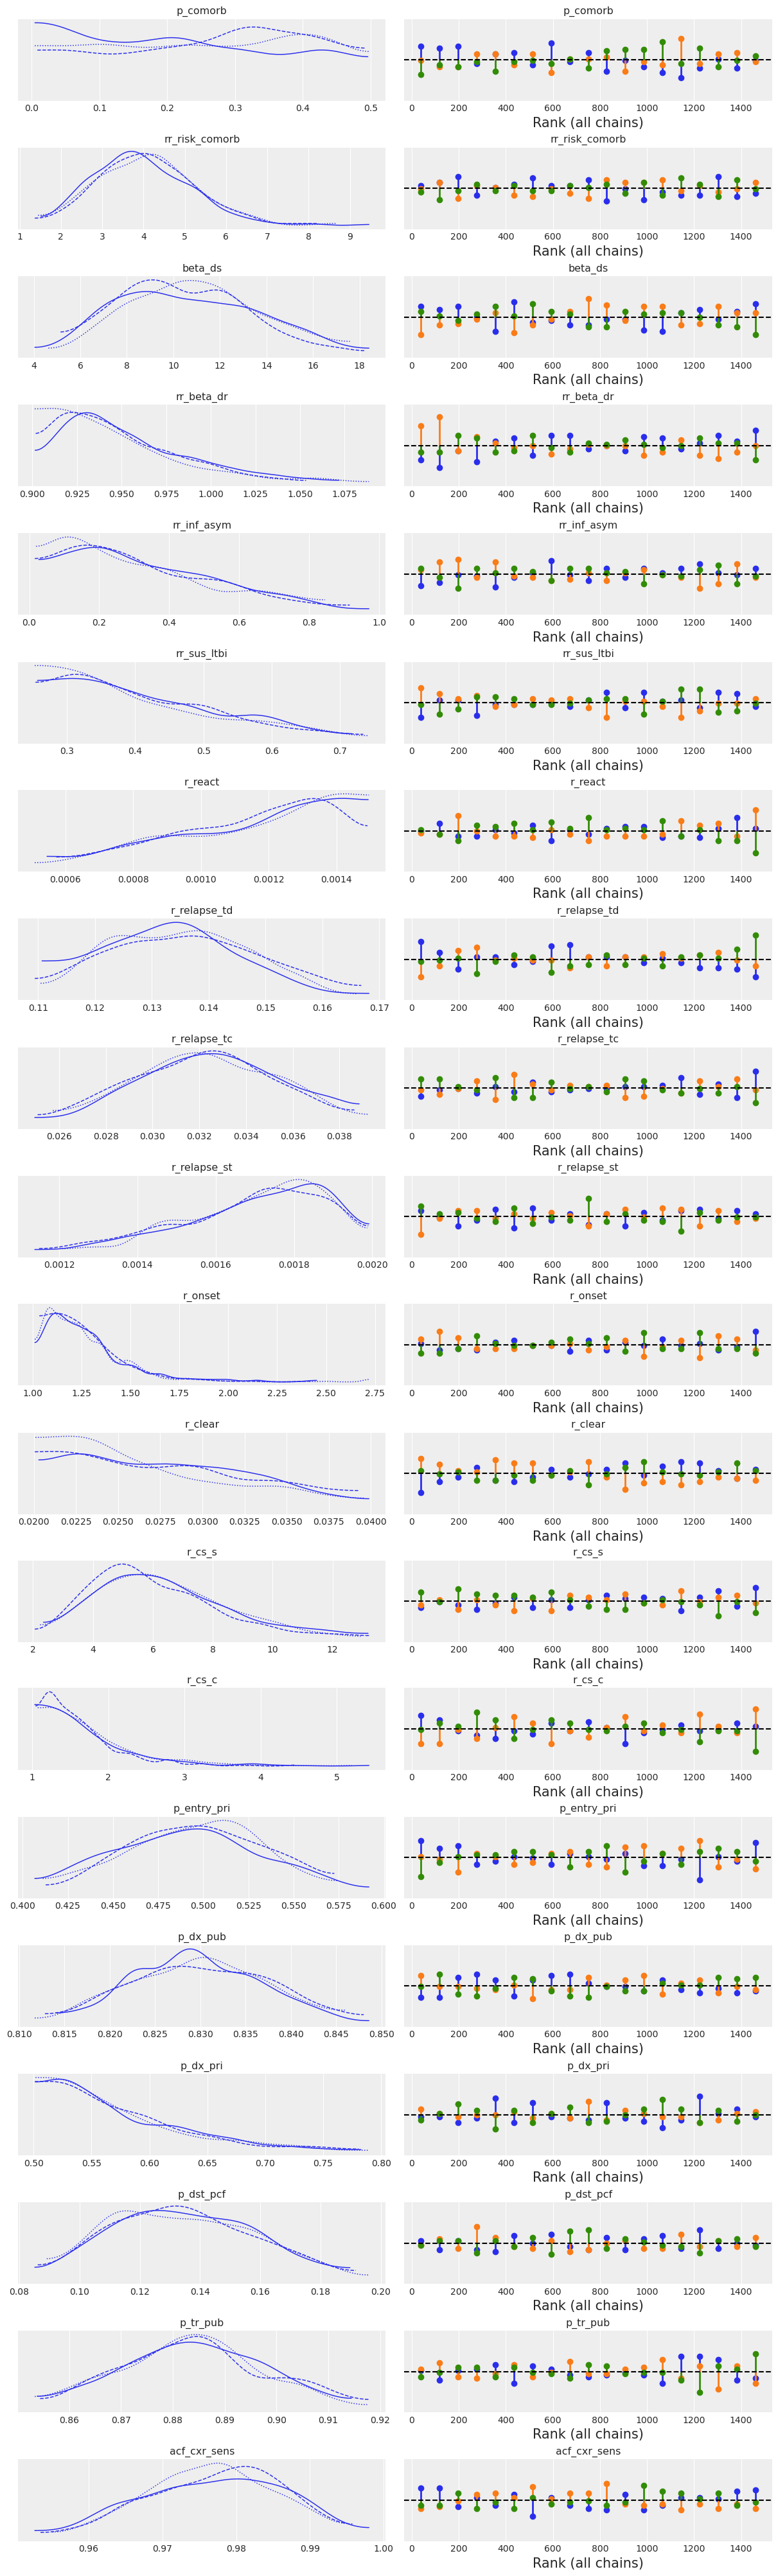

In [6]:
sel = 'out/dy_mul'

ppost = collect_post[sel]
fit = collect_fit[sel]

figs = az.plot_trace(fit, kind="rank_vlines")

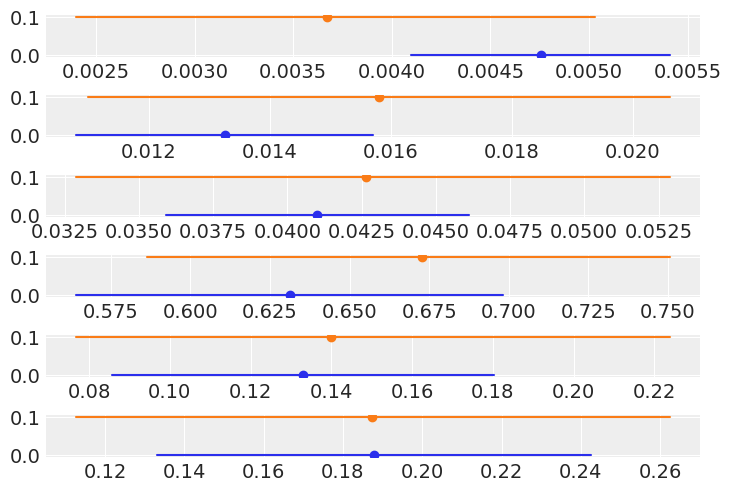

In [8]:
ppost = collect_post['out/dy_mul']

obs, eps = src.Obs, src.Eps

fig, ax = plt.subplots(nrows=len(obs))


m = np.mean(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 1)
l = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.025, 1)
u = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.975, 1)

for i in range(len(obs)):
    ax[i].scatter(obs[i], 0)
    ax[i].plot([obs[i] - eps[i], obs[i] + eps[i]], [0, 0])
    
    ax[i].scatter(m[i], 0.1)
    ax[i].plot([l[i], u[i]], [0.1, 0.1])

## Output completed fits

In [ ]:
for out_path, exo, completed in scenarios:
    if completed:
        fit = collect_fit[out_path]
        
        posts = post_to_particles(fit)
        posts = [src.serve(post) for post in posts]

        with open(f'{out_path}/Post.json', 'w') as f:
            json.dump(posts, f)
